In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Dataset

Este conjunto de dados contém informações sobre a relação entre atributos pessoais (idade, sexo, IMC, tamanho da família, tabagismo), fatores geográficos e seu impacto nos custos do seguro saúde.

| Variável   | Descrição                                                                 |
|------------|---------------------------------------------------------------------------|
| age      | A idade da pessoa segurada.                                                |
| sex       | Gênero (masculino ou feminino) do segurado.                                |
| bmi        | Índice de Massa Corporal, medida da gordura corporal baseada em peso e altura. |
| children     | Número de dependentes abrangidos pelo seguro.                              |
| smoker    | Indica se o segurado é fumante (sim ou não).                               |
| region     | Área geográfica de cobertura do seguro.                                   |
| charges   | Custos do seguro de saúde incorridos pela pessoa segurada.                |


## BMI

| Classificação do BMI | Faixa de BMI (kg/m²) | Descrição                         |
|----------------------|---------------------|-----------------------------------|
| Abaixo do peso       | < 18,5              | Peso abaixo do recomendado        |
| Peso normal          | 18,5 – 24,9         | Peso adequado                     |
| Sobrepeso            | 25,0 – 29,9         | Acima do peso recomendado         |
| Obesidade Grau I     | 30,0 – 34,9         | Obesidade leve                    |
| Obesidade Grau II    | 35,0 – 39,9         | Obesidade moderada                |
| Obesidade Grau III   | ≥ 40,0              | Obesidade grave                   |


---

# Objetivo

Predizer o valor do contrato com base em variáveis socioeconômicas e comportamentais.

In [2]:
df = pd.read_csv('.\insurance.csv')

################################################

# Criei as bins com as categorias do IMC

bins = [0, 18.5, 25, 30, 35, 40, float('inf')]
labels = [
    'Abaixo do peso',
    'Peso normal',
    'Sobrepeso',
    'Obesidade Grau I',
    'Obesidade Grau II',
    'Obesidade Grau III'
]

df['bmi_categoria'] = pd.cut(
    df['bmi'],
    bins=bins,
    labels=labels,
    right=False
)

df

,age,sex,bmi,children,smoker,region,charges,bmi_categoria
0,19,female,27.900,0,yes,southwest,16884.92400,Sobrepeso
1,18,male,33.770,1,no,southeast,1725.55230,Obesidade Grau I
2,28,male,33.000,3,no,southeast,4449.46200,Obesidade Grau I
3,33,male,22.705,0,no,northwest,21984.47061,Peso normal
4,32,male,28.880,0,no,northwest,3866.85520,Sobrepeso
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,Obesidade Grau I
1334,18,female,31.920,0,no,northeast,2205.98080,Obesidade Grau I
1335,18,female,36.850,0,no,southeast,1629.83350,Obesidade Grau II
1336,21,female,25.800,0,no,southwest,2007.94500,Sobrepeso


In [3]:
df.nunique()

age                47
sex                 2
bmi               548
children            6
smoker              2
region              4
charges          1337
bmi_categoria       6
dtype: int64

In [4]:
# Valores nulos

df.isnull().sum()

age              0
sex              0
bmi              0
children         0
smoker           0
region           0
charges          0
bmi_categoria    0
dtype: int64

In [5]:
# Dimensão do dataset

print(f'O conjunto de dados possui {df.shape[0]} linhas e {df.shape[1]} colunas.')
print(df.dtypes)

O conjunto de dados possui 1338 linhas e 8 colunas.
age                 int64
sex                object
bmi               float64
children            int64
smoker             object
region             object
charges           float64
bmi_categoria    category
dtype: object


# Análise descritiva

## Variáveis Quantitativas


- ```Contagem``` (count)
- ```Média``` (mean)
- ```Desvio padrão``` (std) - *dispersão dos dados*
- ```Mínimo``` (min)
- ```Quartis``` (25%, 50%, 75%)
- ```Máximo``` (max)

### age
Idade média de ```39 anos```, com valores mínimos de 18 e máximo de 64.

### bmi
A média e a mediana do IMC indicam tendência à obesidade leve na população

### children
25% dos indivíduos não possuem filhos, enquanto o valor máximo observado é 5 filhos.

### charges
Variável com maior ```dispersão dos dados``` com possível presença de valores extremos, devendo ser investigada com técnicas de detecção de outliers.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


## Variáveis Qualitativas

### sex
A variável possui **duas categorias**, sendo **male** a mais frequente, com **676 registros**, indicando leve predominância do sexo masculino na base de dados.

### smoker
Variável binária com duas categorias. A maioria dos indivíduos **não é fumante**, totalizando **1.064 registros**, o que representa a maior parte da amostra.

### region
A variável apresenta **quatro categorias distintas**. A região **southeast** é a mais frequente, com **364 ocorrências**, indicando maior concentração de segurados nessa região.


In [7]:
df.describe(include=['object']).T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


# Gráficos para análise

In [8]:
def hist_box(x, titulo_hist, titulo_box):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(df[x], kde=True, bins=20, ax=axes[0])
    axes[0].set_title(titulo_hist)

    axes[1].boxplot(df[x], vert=False)
    axes[1].set_title(titulo_box)

    plt.tight_layout()
    plt.show()

def plot_bar(x, titulo_grafico):
    counts = df[x].value_counts().sort_index()

    plt.figure(figsize=(6, 4))
    plt.bar(counts.index, counts.values)
    plt.title(titulo_grafico)
    plt.xlabel(x)
    plt.ylabel('Frequência')
    plt.show()

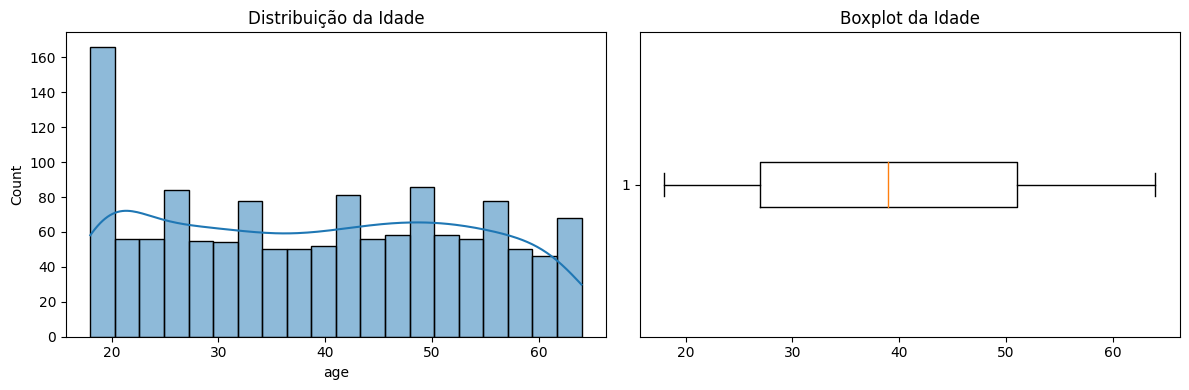

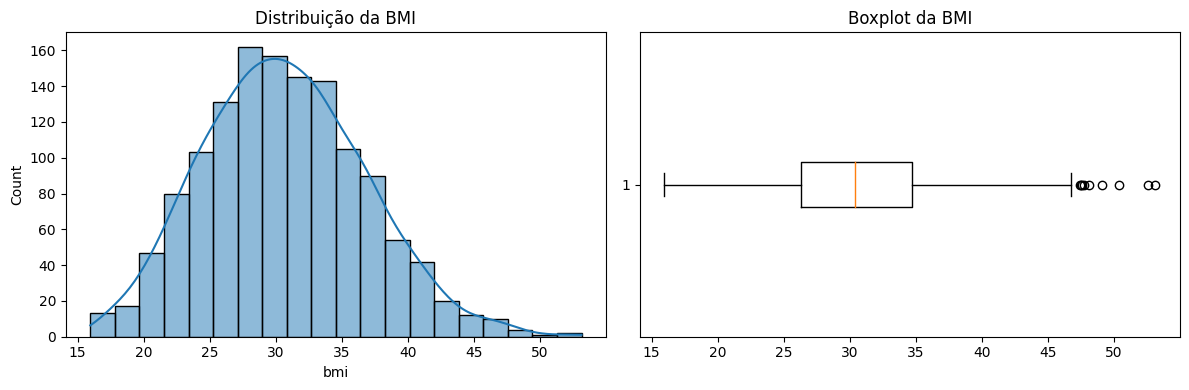

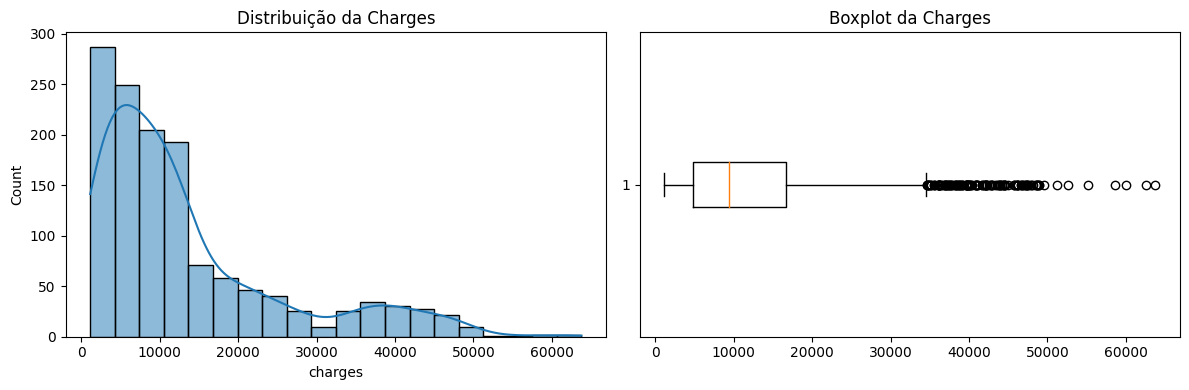

In [9]:
hist_box('age', 'Distribuição da Idade', 'Boxplot da Idade')
hist_box('bmi', 'Distribuição da BMI', 'Boxplot da BMI')
hist_box('charges', 'Distribuição da Charges', 'Boxplot da Charges')

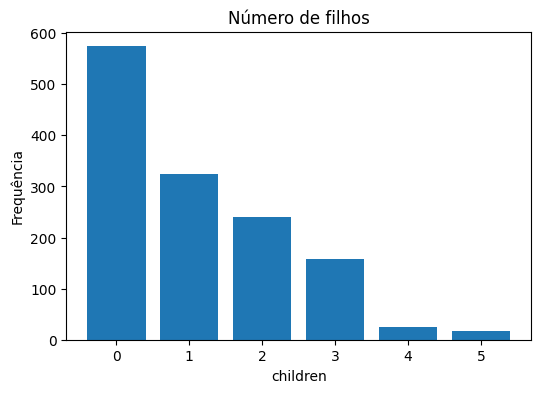

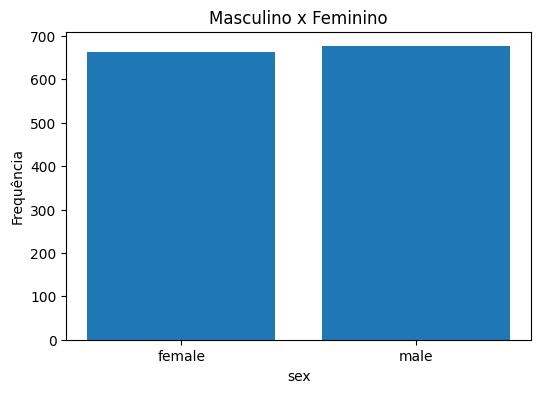

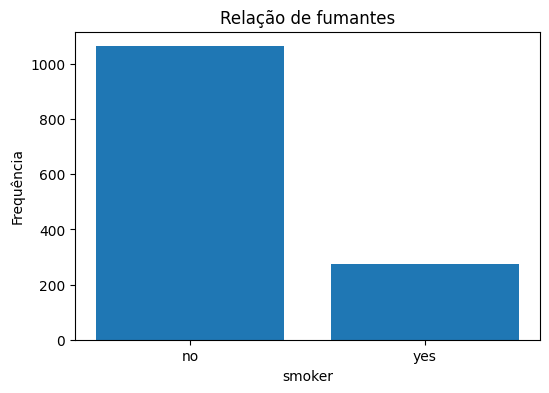

In [10]:
plot_bar('children', 'Número de filhos')
plot_bar('sex', 'Masculino x Feminino')
plot_bar('smoker', 'Relação de fumantes')

# Comparativo entre as variáveis

Pensando no objetivo do projeto, vou comparar algumas variáveis para entender sua relação com ```charges```.

In [11]:
def scat_plot(x,hue):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df, x=x, y='charges', hue=hue)
    plt.title(f"Relação entre {x} x Custo do seguro com {hue}")
    plt.xlabel(x)
    plt.ylabel("Custo do Seguro")
    plt.show()

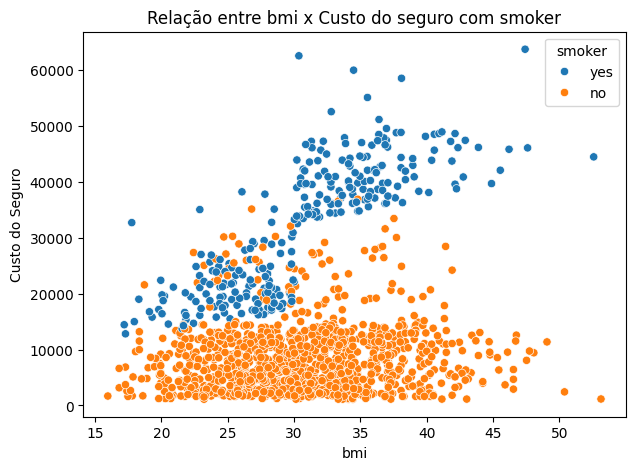

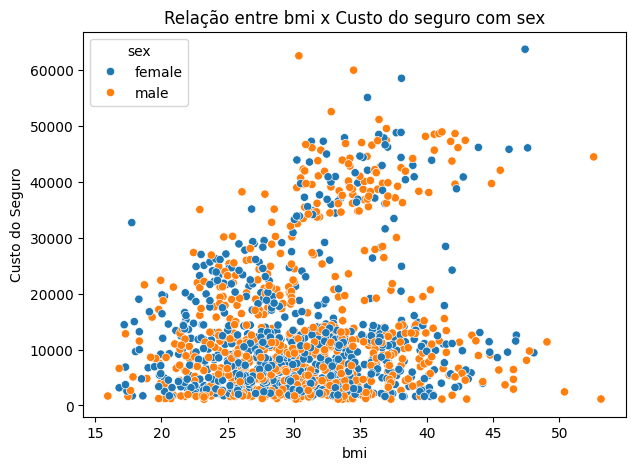

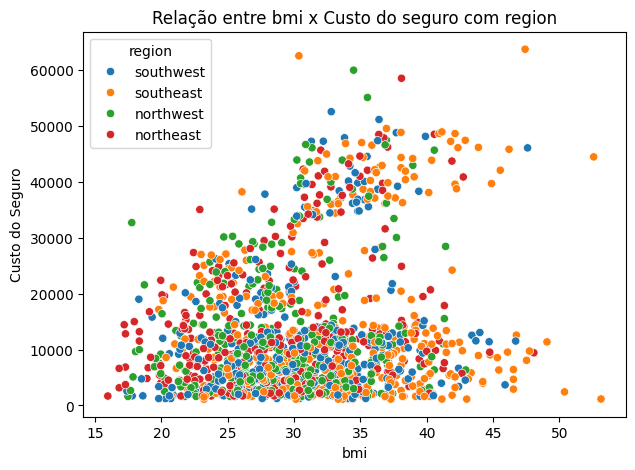

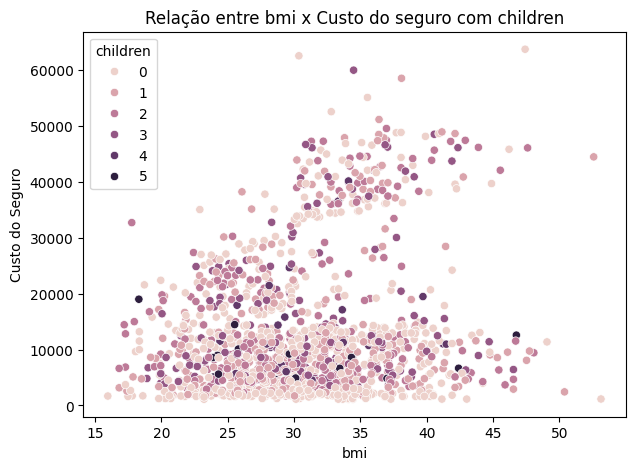

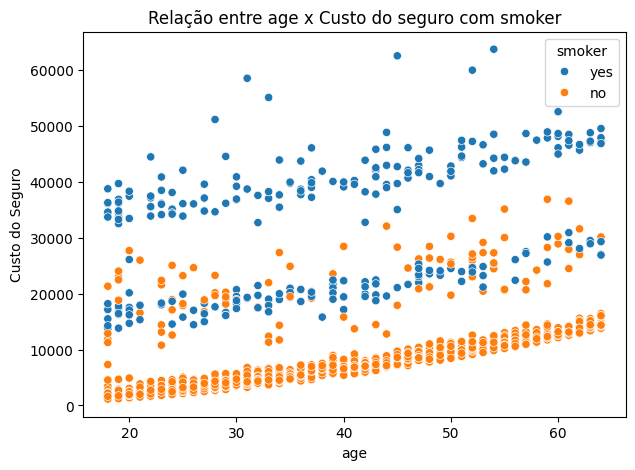

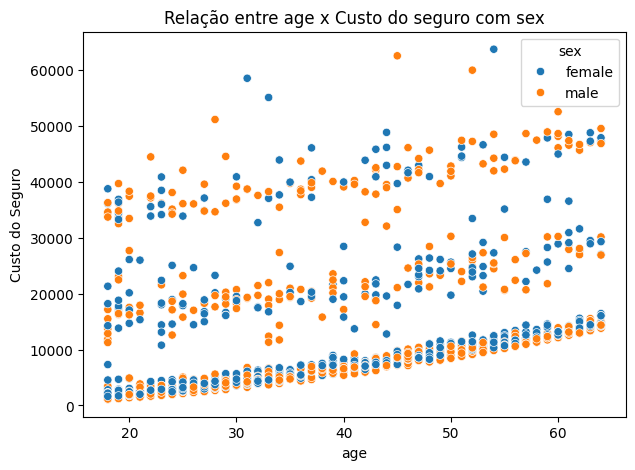

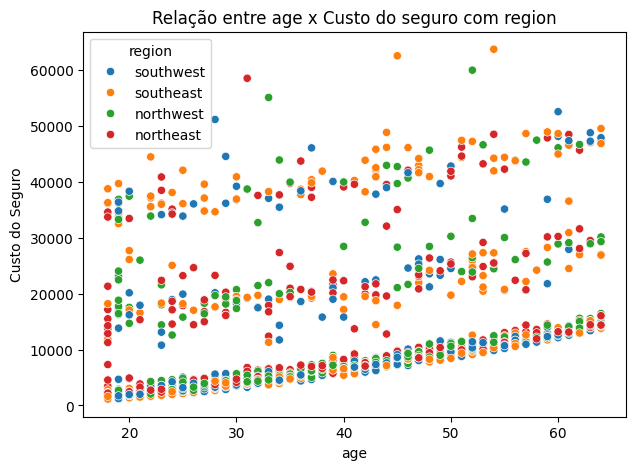

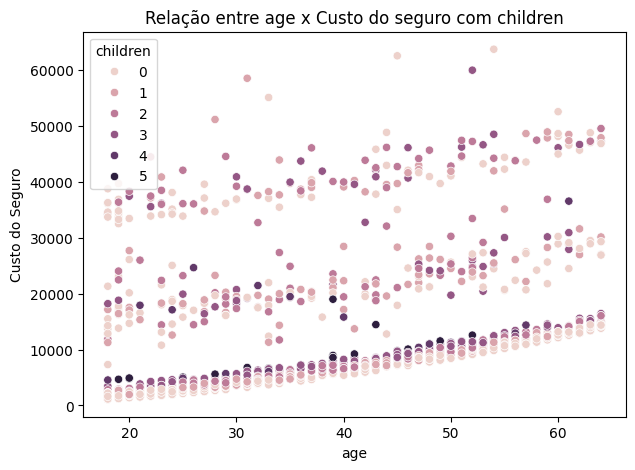

In [12]:
scat_plot('bmi','smoker')
scat_plot('bmi','sex')
scat_plot('bmi','region')
scat_plot('bmi','children')

scat_plot('age','smoker')
scat_plot('age','sex')
scat_plot('age','region')
scat_plot('age','children')

# Correlação

In [13]:
df_corr = pd.get_dummies(df, drop_first=True)
df_corr = df_corr.astype(int)

corr = df_corr.select_dtypes(include='number').corr()

corr

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_categoria_Peso normal,bmi_categoria_Sobrepeso,bmi_categoria_Obesidade Grau I,bmi_categoria_Obesidade Grau II,bmi_categoria_Obesidade Grau III
age,1.000000,0.108437,0.042469,0.299009,-0.020856,-0.025019,-0.000407,-0.011642,0.010016,-0.079191,-0.012910,0.007846,0.086994,0.026455
bmi,0.108437,1.000000,0.011097,0.196188,0.046503,0.001669,-0.138495,0.271303,-0.004313,-0.593577,-0.322638,0.179355,0.481424,0.550546
children,0.042469,0.011097,1.000000,0.067999,0.017163,0.007673,0.024806,-0.023066,0.021914,0.012675,-0.020039,0.028485,-0.023807,0.003356
charges,0.299009,0.196188,0.067999,1.000000,0.057293,0.787251,-0.039905,0.073981,-0.043210,-0.106266,-0.120084,0.061003,0.139350,0.078421
sex_male,-0.020856,0.046503,0.017163,0.057293,1.000000,0.076185,-0.011156,0.017117,-0.004184,-0.022690,-0.026460,0.021215,0.017278,0.029829
smoker_yes,-0.025019,0.001669,0.007673,0.787251,0.076185,1.000000,-0.036945,0.068498,-0.036945,0.019430,-0.020629,-0.024720,0.019430,0.017395
region_northwest,-0.000407,-0.138495,0.024806,-0.039905,-0.011156,-0.036945,1.000000,-0.346265,-0.320829,0.038898,0.050934,0.038422,-0.091577,-0.097633
region_southeast,-0.011642,0.271303,-0.023066,0.073981,0.017117,0.068498,-0.346265,1.000000,-0.346265,-0.090755,-0.092712,-0.045683,0.147237,0.201747
region_southwest,0.010016,-0.004313,0.021914,-0.043210,-0.004184,-0.036945,-0.320829,-0.346265,1.000000,-0.030999,0.027853,0.026926,0.015599,-0.063021
bmi_categoria_Peso normal,-0.079191,-0.593577,0.012675,-0.106266,-0.022690,0.019430,0.038898,-0.090755,-0.030999,1.000000,-0.286298,-0.288906,-0.202156,-0.121459


## Observação

Parece-me que ```smoker_yes``` e ```age```possuem as maiores correlações. Vou criar uma nova variável me baseando nessas duas e testar a correlação.

Outra questão que percebi foi que, pensando no objetivo do projeto, acredito que o ```BMI``` também seja importante, visto que está ligado diretamente ao bem estar, indicando um grau de saúde.

In [14]:
df_corr['bmi_smoker'] = df_corr['bmi'] * df_corr['smoker_yes']
df_corr['age_smoker'] = df_corr['age'] * df_corr['smoker_yes']

corr = df_corr.select_dtypes(include='number').corr()
corr

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_categoria_Peso normal,bmi_categoria_Sobrepeso,bmi_categoria_Obesidade Grau I,bmi_categoria_Obesidade Grau II,bmi_categoria_Obesidade Grau III,bmi_smoker,age_smoker
age,1.000000,0.108437,0.042469,0.299009,-0.020856,-0.025019,-0.000407,-0.011642,0.010016,-0.079191,-0.012910,0.007846,0.086994,0.026455,-0.018708,0.144777
bmi,0.108437,1.000000,0.011097,0.196188,0.046503,0.001669,-0.138495,0.271303,-0.004313,-0.593577,-0.322638,0.179355,0.481424,0.550546,0.108601,0.011226
children,0.042469,0.011097,1.000000,0.067999,0.017163,0.007673,0.024806,-0.023066,0.021914,0.012675,-0.020039,0.028485,-0.023807,0.003356,0.006187,0.020320
charges,0.299009,0.196188,0.067999,1.000000,0.057293,0.787251,-0.039905,0.073981,-0.043210,-0.106266,-0.120084,0.061003,0.139350,0.078421,0.845706,0.789252
sex_male,-0.020856,0.046503,0.017163,0.057293,1.000000,0.076185,-0.011156,0.017117,-0.004184,-0.022690,-0.026460,0.021215,0.017278,0.029829,0.089196,0.069657
smoker_yes,-0.025019,0.001669,0.007673,0.787251,0.076185,1.000000,-0.036945,0.068498,-0.036945,0.019430,-0.020629,-0.024720,0.019430,0.017395,0.973502,0.926984
region_northwest,-0.000407,-0.138495,0.024806,-0.039905,-0.011156,-0.036945,1.000000,-0.346265,-0.320829,0.038898,0.050934,0.038422,-0.091577,-0.097633,-0.048641,-0.029346
region_southeast,-0.011642,0.271303,-0.023066,0.073981,0.017117,0.068498,-0.346265,1.000000,-0.346265,-0.090755,-0.092712,-0.045683,0.147237,0.201747,0.096306,0.074633
region_southwest,0.010016,-0.004313,0.021914,-0.043210,-0.004184,-0.036945,-0.320829,-0.346265,1.000000,-0.030999,0.027853,0.026926,0.015599,-0.063021,-0.033600,-0.048784
bmi_categoria_Peso normal,-0.079191,-0.593577,0.012675,-0.106266,-0.022690,0.019430,0.038898,-0.090755,-0.030999,1.000000,-0.286298,-0.288906,-0.202156,-0.121459,-0.045354,0.016137


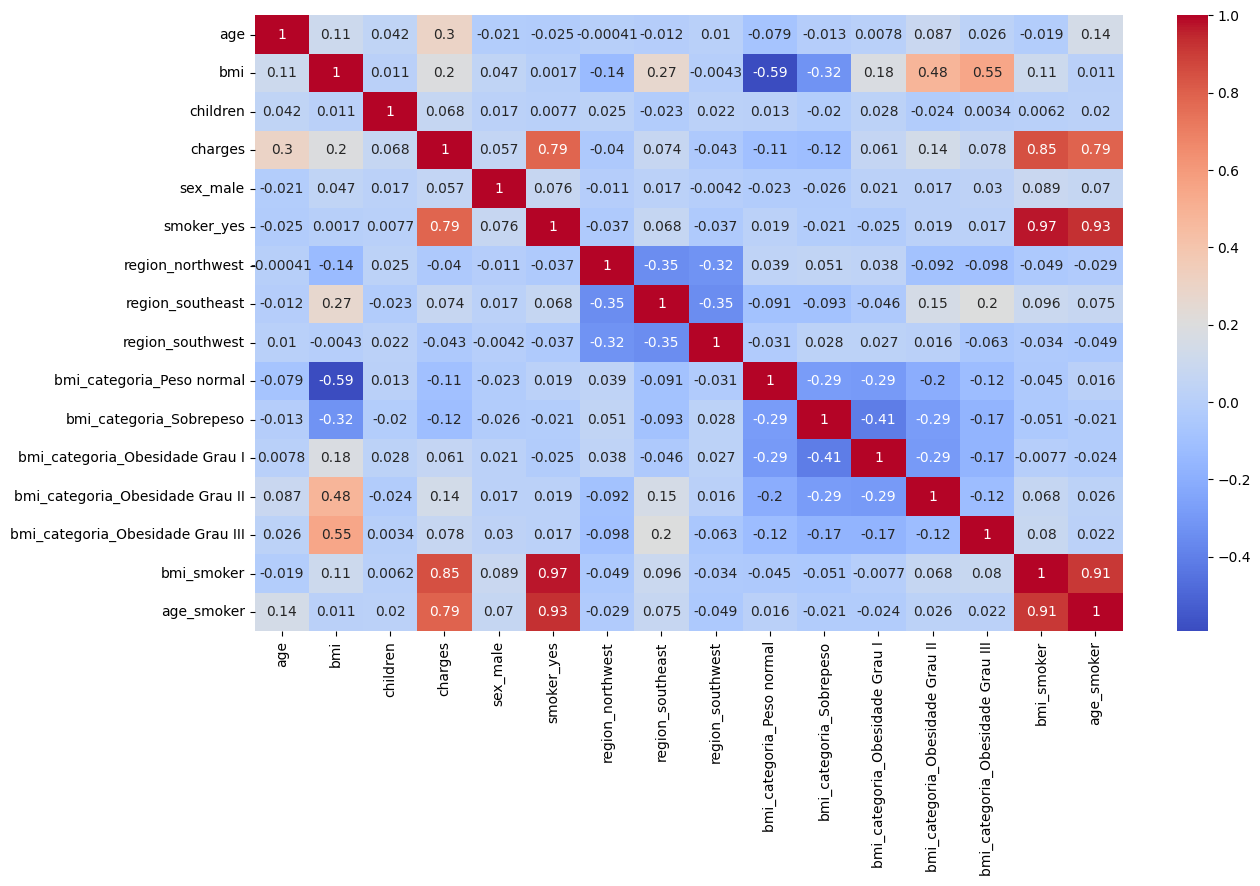

In [15]:
plt.figure(figsize=(14,8))
sns.heatmap(df_corr.corr(numeric_only=True), 
            annot=True, 
            cmap="coolwarm")
plt.show()

# VIF

As variáveis ```bmi``` e ```smoker_yes``` foram removidas por apresentarem forte multicolinearidade e por não acrescentarem informação explicativa adicional ao modelo, uma vez que seus efeitos passaram a ser capturados de forma mais adequada pelas variáveis de interação.


Essas variáveis já respondem duas questões:
> quem é fumante (bmi_smoker)

> qual é o IMC / idade no contexto de ser fumante (age_smoker)

In [16]:
features = [
    'age',
    'children',
    'sex_male',
    'bmi_smoker',
    'age_smoker',
    'region_northwest',
    'region_southeast',
    'region_southwest'
]

y = df_corr['charges']
X = df_corr[features]

In [17]:
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif.sort_values(by='VIF', ascending=False)

,feature,VIF
4,age_smoker,7.556330
3,bmi_smoker,7.480595
0,age,4.189640
2,sex_male,1.905809
6,region_southeast,1.851156
7,region_southwest,1.765849
1,children,1.763940
5,region_northwest,1.729191
